In [1]:
import os
from collections import defaultdict
!CUDA_LAUNCH_BLOCKING=1
from fastai.vision import *

In [2]:
labels = set([x.split('_')[0] for x in os.listdir('../VOCdevkit/VOC2007/ImageSets/Main') if '_' in x])
print(labels)

{'diningtable', 'train', 'bus', 'horse', 'pottedplant', 'aeroplane', 'cow', 'motorbike', 'boat', 'sofa', 'bird', 'person', 'bicycle', 'tvmonitor', 'sheep', 'bottle', 'chair', 'cat', 'dog', 'car'}


In [3]:
dicio = {}
path = '../VOCdevkit/VOC2007/ImageSets/Main/'
for labels in [x for x in os.listdir(path) if '_trainval' in x]:
    for image in open(path+labels):
        code, label = image.split()
        tag = labels.split('_')[0]
        if label == "1":
            if code in dicio:
                dicio[code] += (' ' + tag)
            else:
                dicio[code] = tag

In [4]:
df = pd.DataFrame.from_dict(dicio, orient='index', columns=['tags'])
df.index.name = 'image_name'
df.reset_index(inplace=True)

In [5]:
df.head(10)

image_name        tags
0     000021  dog person
1     000036         dog
2     000063   dog chair
3     000065         dog
4     000078         dog
5     000093   dog chair
6     000112   dog chair
7     000120         dog
8     000140    dog sofa
9     000171  dog person

In [6]:
tfms = get_transforms(max_zoom=1.05)

In [7]:
np.random.seed(42) # set random seed so we always get the same validation set
path = '../VOCdevkit/VOC2007/'
src = (ImageList.from_df(df, path, folder='JPEGImages', suffix='.jpg')
       # Load data from csv
       .split_by_rand_pct(0.2)
       # split data into training and validation set (20% validation)
       .label_from_df(label_delim=' ')
       # label data using the tags column (second column is default)
)

In [8]:
data = (src.transform(tfms, size=300)
        # Apply transforms and scale images to 128x128
        .databunch(bs=64).normalize(imagenet_stats)
        # Create databunch with batchsize=64 and normalize the images
)

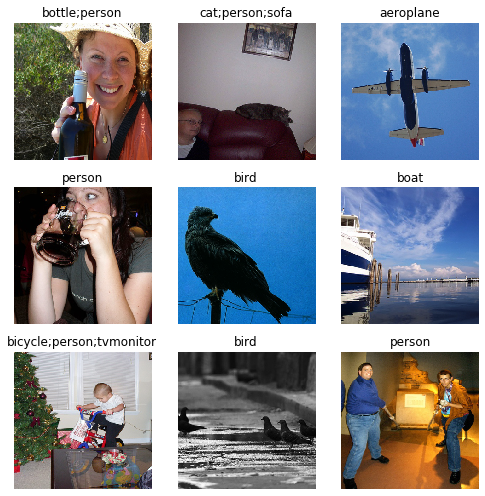

In [9]:
data.show_batch(rows=3, figsize=(7, 7))

In [10]:
# create metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
# create cnn with the resnet50 architecture
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score], pretrained=True)

In [11]:
print(learn)

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: MultiCategoryList
dog;person,dog,dog;chair,dog,dog
Path: ../VOCdevkit/VOC2007;

Valid: LabelList (1002 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: MultiCategoryList
horse,person;car,diningtable;person,train,boat
Path: ../VOCdevkit/VOC2007;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


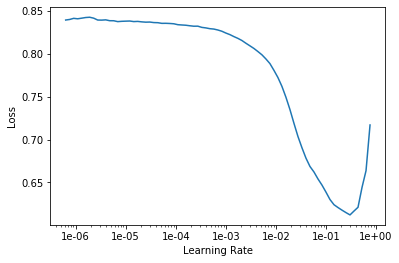

In [12]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

In [13]:
learn.fit_one_cycle(5, 0.01)
learn.save('voc-weights-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


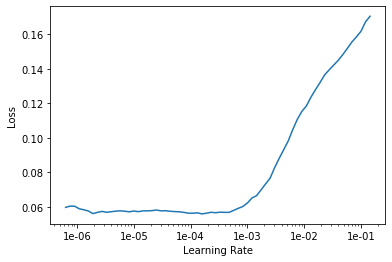

In [14]:
learn.unfreeze() # unfreeze all layers

learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

In [15]:
learn.fit_one_cycle(5, max_lr=1e-5)
learn.save('voc-weights-stage-2')

In [16]:
learn.export()

In [23]:
df = pd.read_csv('../VOCdevkit/VOC2007/ImageSets/Main/test.txt', names=['image_name'], dtype={'image_name': object})
df.head()

image_name
0     000001
1     000002
2     000003
3     000004
4     000006

In [19]:
path = '../VOCdevkit/VOC2007/'
src_test = (ImageList.from_df(df, path, folder='JPEGImages', suffix='.jpg'))

In [20]:
learn = load_learner(path, test=src_test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [37]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f[:-4] for f in learn.data.test_ds.items]
df = pd.DataFrame(preds.numpy(), columns=learn.data.train_ds.classes, index=fnames)
df.index.name = 'image_name'
df.reset_index(inplace=True)
df.head()

image_name  aeroplane   bicycle      bird  \
0  ../VOCdevkit/VOC2007/JPEGImages/000001   0.000009  0.003700  0.000121   
1  ../VOCdevkit/VOC2007/JPEGImages/000002   0.000035  0.000422  0.000030   
2  ../VOCdevkit/VOC2007/JPEGImages/000003   0.001512  0.014000  0.005531   
3  ../VOCdevkit/VOC2007/JPEGImages/000004   0.000133  0.001697  0.000158   
4  ../VOCdevkit/VOC2007/JPEGImages/000006   0.001168  0.003983  0.000566   

       boat    bottle       bus       car       cat     chair  ...  \
0  0.000085  0.006415  0.000187  0.000574  0.000169  0.032218  ...   
1  0.000039  0.000084  0.001305  0.007538  0.000081  0.001122  ...   
2  0.002471  0.001349  0.023777  0.261115  0.005136  0.016268  ...   
3  0.000473  0.000087  0.077756  0.999135  0.000169  0.000898  ...   
4  0.000742  0.014424  0.000289  0.000361  0.013557  0.969738  ...   

   diningtable       dog     horse  motorbike    person  pottedplant  \
0     0.000599  0.998163  0.000019   0.000100  0.938003     0.000541   
1     0.000109  0.000102  0.000060   0.000083  0.014799     0.005869   
2     0.002056  0.000250  0.004906   0.005654  0.044492     0.372422   
3     0.000110  0.000084  0.000232   0.001797  0.027546     0.021211   
4     0.614970  0.003402  0.000806   0.000356  0.009422     0.116149   

      sheep      sofa     train  tvmonitor  
0  0.002602  0.003039  0.000097   0.001199  
1  0.000520  0.000248  0.999719   0.000582  
2  0.002197  0.003783  0.046776   0.013659  
3  0.000054  0.003324  0.001034   0.000635  
4  0.000842  0.639571  0.000350   0.178715  

[5 rows x 21 columns]

In [43]:
exp_id = 'comp2'
tset = 'test'
for index, cls in enumerate(learn.data.train_ds.classes):
    with open("../results/VOC2007/Main/{}_cls_{}_{}.txt".format(exp_id, tset, cls), 'w') as fout:
        for x in df.values:
            res = "{} {}\n".format(x[0].split('/')[-1], "{:.6f}".format(x[index+1]))
            fout.write(res)